<a href="https://colab.research.google.com/github/jkundycki/dsc-mod-4-project-v2-1-online-ds-ft-120919/blob/master/Project4Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Movie Recommendation System based on User Ratings

Importing and Loading the Data:

In [0]:
#Install PySpark Packages
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
#Import Libraries
import numpy as np
import pandas as pd

#Import Libraries for Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

#Import Warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Import os for PySpark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
#Import PySpark
import findspark
findspark.init()
from pyspark.sql import SparkSession

#Instantiate the SparkSession Object
spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [0]:
#Load the MovieLens Datasets into the PySpark DataFrame
ratings = spark.read.csv('/content/ratings.csv', header='true', inferSchema='true')
movies = spark.read.csv('/content/movies.csv', header='true', inferSchema='true')

In [6]:
#Check columns for loaded csv files
ratings.head(5)

[Row(userId=1, movieId=1, rating=4.0, timestamp=964982703),
 Row(userId=1, movieId=3, rating=4.0, timestamp=964981247),
 Row(userId=1, movieId=6, rating=4.0, timestamp=964982224),
 Row(userId=1, movieId=47, rating=5.0, timestamp=964983815),
 Row(userId=1, movieId=50, rating=5.0, timestamp=964982931)]

In [7]:
#Check columns for loaded csv files
movies.head(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [0]:
#Drop Timestamp from ratings
ratings = ratings.drop('timestamp')

### Preparing a Pandas df

In [0]:
moviesdf = pd.read_csv('movies.csv')
ratingsdf = pd.read_csv('ratings.csv')

In [10]:
moviesdf.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [11]:
ratingsdf.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [0]:
#Merge Ratings and Movies on movieId
merged_df = pd.merge(moviesdf,ratingsdf, on=['movieId'])

In [0]:
#Drop timestamp column
merged_df = merged_df.drop(columns='timestamp')

In [14]:
print(merged_df.shape)
merged_df.head()

(100836, 5)


,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


## Exploring the Data

### Question 1: What are the average User Ratings?

In [0]:
rating_counts = merged_df['rating'].value_counts()
sorted_counts = {k: v for k, v in sorted(rating_counts.items(), key=lambda item: item[1])}
sorted_count = list(sorted_counts.items())
cy = [item[1] for item in sorted_count]
cx = [item[0] for item in sorted_count]

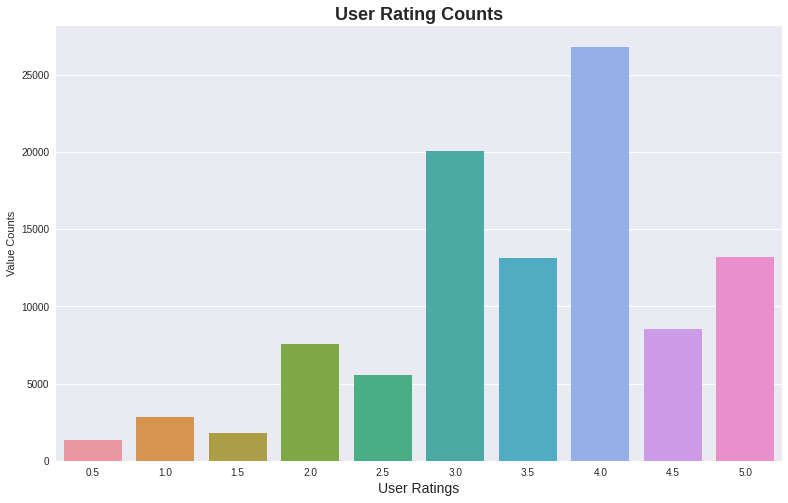

4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64


In [16]:
plt.figure(figsize=(13,8))
sns.barplot(x=cx, y=cy)
plt.title('User Rating Counts', fontweight='bold', fontsize=18)
plt.xlabel('User Ratings',fontsize=14)
plt.ylabel('Value Counts')
plt.show()
print(merged_df['rating'].value_counts(normalize=True))

Users seem to tend to rate movies at least a 3 or above most of the time.

### Question 2: Which Genres tend to get highest ratings?

In [17]:
merged_df['genres'].value_counts()

Comedy                                                            7196
Drama                                                             6291
Comedy|Romance                                                    3967
Comedy|Drama|Romance                                              3000
Comedy|Drama                                                      2851
                                                                  ... 
Action|Animation|Crime|Drama|Film-Noir|Mystery|Sci-Fi|Thriller       1
Adventure|Children|Comedy|Sci-Fi                                     1
Horror|Sci-Fi|Western                                                1
Comedy|Romance|Western                                               1
Adventure|Fantasy|Musical|Romance                                    1
Name: genres, Length: 951, dtype: int64

In [18]:
#Many movie have genre grouping, they will need to be separated and classified to identify each individual genre
merged_df['genres'] = merged_df['genres'].apply(lambda x: x.split("|") if x else x)
merged_df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5


In [0]:
all_genres = set()
for genres in merged_df['genres']:
    if genres:
        all_genres.update(genres)

In [20]:
all_genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [0]:
#Prepare genre columns for genre counts
for genre in all_genres:
  merged_df[genre] = np.zeros(shape=merged_df.shape[0])

In [22]:
#Iterate through the movies and update the genre columns to 1 if the movie contains that genre
for index, row in merged_df.iterrows():
    if row['genres']:
        for genre in row['genres']:
            merged_df.loc[index, genre] = 1
merged_df.head()

,movieId,title,genres,userId,rating,Comedy,Crime,Musical,Romance,Mystery,Children,War,Sci-Fi,Documentary,Action,(no genres listed),Film-Noir,IMAX,Thriller,Horror,Western,Fantasy,Drama,Adventure,Animation
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [23]:
titles = pd.DataFrame([])
titles['title'] = moviesdf['title']
titles.head()

,title
0,Toy Story (1995)
1,Jumanji (1995)
2,Grumpier Old Men (1995)
3,Waiting to Exhale (1995)
4,Father of the Bride Part II (1995)


In [24]:
for genre in all_genres:
  print(genre)
  print(merged_df.loc[merged_df[genre]==1, ['rating']].mean())

Comedy
rating    3.384721
dtype: float64
Crime
rating    3.658294
dtype: float64
Musical
rating    3.563678
dtype: float64
Romance
rating    3.506511
dtype: float64
Mystery
rating    3.63246
dtype: float64
Children
rating    3.412956
dtype: float64
War
rating    3.808294
dtype: float64
Sci-Fi
rating    3.455721
dtype: float64
Documentary
rating    3.797785
dtype: float64
Action
rating    3.447984
dtype: float64
(no genres listed)
rating    3.489362
dtype: float64
Film-Noir
rating    3.920115
dtype: float64
IMAX
rating    3.618335
dtype: float64
Thriller
rating    3.493706
dtype: float64
Horror
rating    3.258195
dtype: float64
Western
rating    3.583938
dtype: float64
Fantasy
rating    3.491001
dtype: float64
Drama
rating    3.656184
dtype: float64
Adventure
rating    3.508609
dtype: float64
Animation
rating    3.629937
dtype: float64


In [25]:
genre_rating = []
genres = []
for genre in all_genres:
    genres.append(genre)
    genre_rating.append(merged_df.loc[merged_df[genre]==1, ['rating']].mean())
genre_rating

[rating    3.384721
 dtype: float64, rating    3.658294
 dtype: float64, rating    3.563678
 dtype: float64, rating    3.506511
 dtype: float64, rating    3.63246
 dtype: float64, rating    3.412956
 dtype: float64, rating    3.808294
 dtype: float64, rating    3.455721
 dtype: float64, rating    3.797785
 dtype: float64, rating    3.447984
 dtype: float64, rating    3.489362
 dtype: float64, rating    3.920115
 dtype: float64, rating    3.618335
 dtype: float64, rating    3.493706
 dtype: float64, rating    3.258195
 dtype: float64, rating    3.583938
 dtype: float64, rating    3.491001
 dtype: float64, rating    3.656184
 dtype: float64, rating    3.508609
 dtype: float64, rating    3.629937
 dtype: float64]

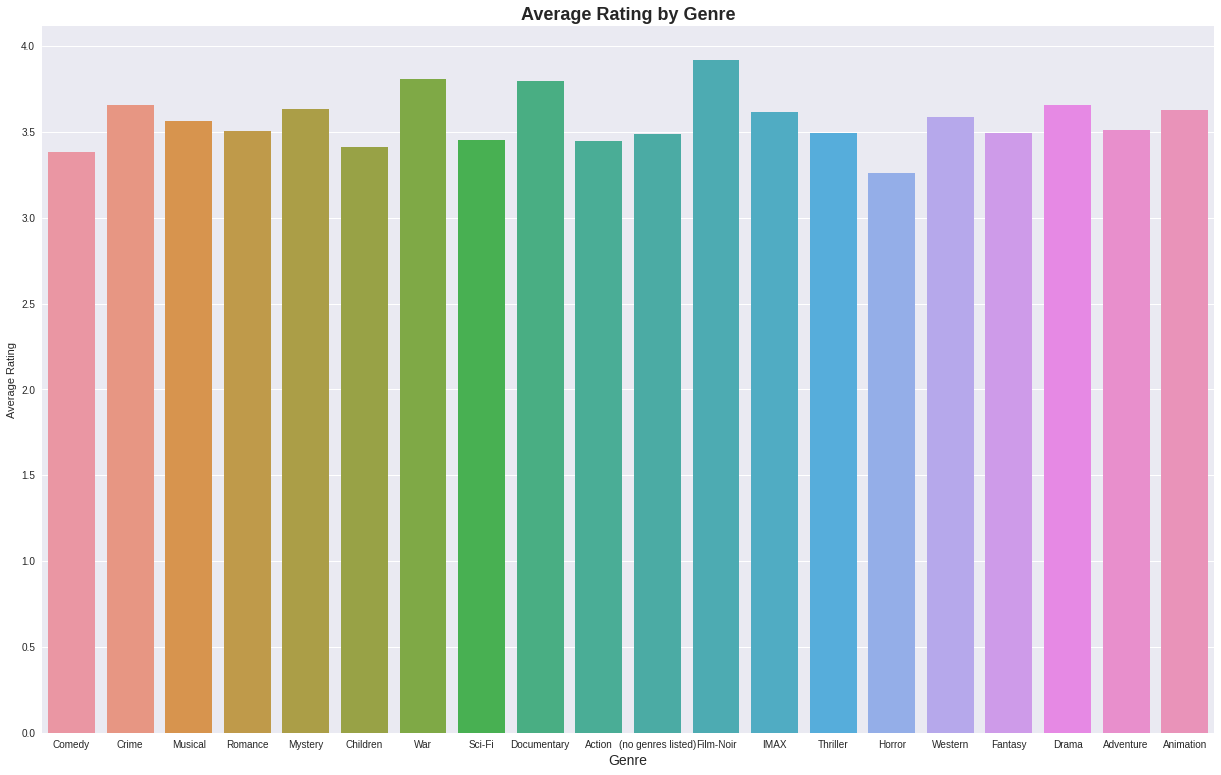

In [26]:
plt.figure(figsize=(21,13))
sns.barplot(x=genres, y=genre_rating)
plt.title('Average Rating by Genre', fontweight='bold', fontsize=18)
plt.xlabel('Genre',fontsize=14)
plt.ylabel('Average Rating')
plt.show()

### Question 3: Which Movies are the Highest Rated?

In [27]:
print(merged_df.loc[merged_df[genre]==1, ['rating']].mean())

rating    3.629937
dtype: float64


In [28]:
mratings = pd.DataFrame(merged_df.groupby('title')['rating'].mean())
mratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [29]:
top50 = mratings.sort_values(by=['rating'], ascending=False)[:100]
top50

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
...,...
Sisters (Syostry) (2001),5.0
"Wings, Legs and Tails (1986)",5.0
Winnie Pooh (1969),5.0


Many movies on MovieLens have received perfect scores.

## Building a Recommender System

In [0]:
# Fit a Model using ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Split ratings into a training and a test set
(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [31]:
# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.9707983105389252


In [32]:
# Use CrossValidation to find the optimal parameters for the ALS Model
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(ratings)    

# Rank the best model
best_model.bestModel.rank

50

In [0]:
# Build name retriever that retrieves movey name based on movieId
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movies.movieId == movie_id).take(1)[0]['title']

In [34]:
print(name_retriever(1023, movies))

Winnie the Pooh and the Blustery Day (1968)


## Movie Recommendations

In [0]:
users = ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [36]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]

# use the name retriever function to get the values
name_retriever(first_recommendation,movies)

'Dragon Ball Z: The History of Trunks (Doragon bôru Z: Zetsubô e no hankô!! Nokosareta chô senshi - Gohan to Torankusu) (1993)'

In [37]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

[Row(userId=3, recommendations=[Row(movieId=3142, rating=7.382853031158447), Row(movieId=80126, rating=7.111521244049072), Row(movieId=3525, rating=7.063931941986084), Row(movieId=74532, rating=6.995889663696289), Row(movieId=1034, rating=6.708475589752197)])]

In [0]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
    (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5,rank=4, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1,movie_string,rating))

In [39]:
user_id = 100000
user_ratings_1 = [(user_id,3253,5),
                  (user_id,2459,5),
                  (user_id,2513,4),
                  (user_id,6502,5),
                  (user_id,1091,5),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=ratings,
             movie_title_df=movies,
             num_recs = 5)

Recommendation 1: Truly, Madly, Deeply (1991)  | predicted score :17.931324005126953
Recommendation 2: Opera (1987)  | predicted score :16.739990234375
Recommendation 3: Bachelor Party (1984)  | predicted score :14.38105583190918
Recommendation 4: Bug (2007)  | predicted score :13.894366264343262
Recommendation 5: Cop Out (2010)  | predicted score :13.877161979675293


## Modernizing the Rating System: Converting to Binary (Thumbs Up or Thumbs Down)

In [40]:
ratings.orderBy('userId')

DataFrame[userId: int, movieId: int, rating: double]

In [41]:
ratings.groupBy('userId').mean().show()

+------+-----------+------------------+------------------+
|userId|avg(userId)|      avg(movieId)|       avg(rating)|
+------+-----------+------------------+------------------+
|   148|      148.0| 68668.47916666667|3.7395833333333335|
|   463|      463.0| 4268.393939393939| 3.787878787878788|
|   471|      471.0|36862.857142857145|             3.875|
|   496|      496.0| 41576.93103448276| 3.413793103448276|
|   243|      243.0| 333.6111111111111| 4.138888888888889|
|   392|      392.0|           2356.64|               3.2|
|   540|      540.0| 9285.214285714286|               4.0|
|    31|       31.0|            930.32|              3.92|
|   516|      516.0| 2582.230769230769|3.6923076923076925|
|    85|       85.0|1354.2941176470588|3.7058823529411766|
|   137|      137.0| 2888.709219858156| 3.978723404255319|
|   251|      251.0|19811.434782608696| 4.869565217391305|
|   451|      451.0|             507.0|3.7941176470588234|
|   580|      580.0| 8519.869266055046| 3.52981651376146

In [42]:
ratings.head(5)

[Row(userId=1, movieId=1, rating=4.0),
 Row(userId=1, movieId=3, rating=4.0),
 Row(userId=1, movieId=6, rating=4.0),
 Row(userId=1, movieId=47, rating=5.0),
 Row(userId=1, movieId=50, rating=5.0)]

In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [44]:
avg_ratings = ratings.withColumn("AverageRating", F.col('rating'))
avg_ratings.show()

+------+-------+------+-------------+
|userId|movieId|rating|AverageRating|
+------+-------+------+-------------+
|     1|      1|   4.0|          4.0|
|     1|      3|   4.0|          4.0|
|     1|      6|   4.0|          4.0|
|     1|     47|   5.0|          5.0|
|     1|     50|   5.0|          5.0|
|     1|     70|   3.0|          3.0|
|     1|    101|   5.0|          5.0|
|     1|    110|   4.0|          4.0|
|     1|    151|   5.0|          5.0|
|     1|    157|   5.0|          5.0|
|     1|    163|   5.0|          5.0|
|     1|    216|   5.0|          5.0|
|     1|    223|   3.0|          3.0|
|     1|    231|   5.0|          5.0|
|     1|    235|   4.0|          4.0|
|     1|    260|   5.0|          5.0|
|     1|    296|   3.0|          3.0|
|     1|    316|   3.0|          3.0|
|     1|    333|   5.0|          5.0|
|     1|    349|   4.0|          4.0|
+------+-------+------+-------------+
only showing top 20 rows



In [0]:
ratingsdf['binary_rating'] = np.zeros(shape=ratingsdf.shape[0])

In [47]:
ratingsdf.head()

,userId,movieId,rating,timestamp,binary_rating
0,1,1,4.0,964982703,0.0
1,1,3,4.0,964981247,0.0
2,1,6,4.0,964982224,0.0
3,1,47,5.0,964983815,0.0
4,1,50,5.0,964982931,0.0


In [48]:
ratingsdf.drop(columns='timestamp')

,userId,movieId,rating,binary_rating
0,1,1,4.0,0.0
1,1,3,4.0,0.0
2,1,6,4.0,0.0
3,1,47,5.0,0.0
4,1,50,5.0,0.0
...,...,...,...,...
100831,610,166534,4.0,0.0
100832,610,168248,5.0,0.0
100833,610,168250,5.0,0.0
100834,610,168252,5.0,0.0


In [0]:
binary = []
for i in ratingsdf.rating:
    if i < 3:
        binary.append(0)
    else:
        binary.append(1)
ratingsdf.binary_rating = binary

In [0]:
ratingsdf.to_csv("../content/ratingsbinary.csv")

In [0]:
ratings2 = spark.read.csv('/content/ratingsbinary.csv', header='true', inferSchema='true')

In [52]:
ratings2.head(2)

[Row(_c0=0, userId=1, movieId=1, rating=4.0, timestamp=964982703, binary_rating=1),
 Row(_c0=1, userId=1, movieId=3, rating=4.0, timestamp=964981247, binary_rating=1)]

In [0]:
#Drop Timestamp from ratings2
ratings2 = ratings2.drop('timestamp')

In [0]:
#Drop Timestamp from ratings2
ratings2 = ratings2.drop('rating')

In [0]:
#Drop Timestamp from ratings2
ratings2 = ratings2.drop('_c0')

### Rebuilding the Model (with binary rating system)

In [0]:
# Split ratings into a training and a test set
(training, test) = ratings2.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='binary_rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [57]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='binary_rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.40316882331441833


In [58]:
# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='binary_rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(ratings2)    

# Rank the best model
best_model.bestModel.rank

50

### Movie Recommendation System II

In [0]:
users = ratings2.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [60]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]

# use the name retriever function to get the values
name_retriever(first_recommendation,movies)

'Air Bud (1997)'

In [61]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

[Row(userId=3, recommendations=[Row(movieId=8253, rating=2.400397539138794), Row(movieId=2263, rating=2.3073976039886475), Row(movieId=3794, rating=2.116691827774048), Row(movieId=46967, rating=2.0073180198669434), Row(movieId=78039, rating=1.9372708797454834)])]

In [0]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    print('creating dictionary')
    print(new_ratings)
    print(rating_df['userId', 'movieId', 'binary_rating'].columns)
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    print(new_user_ratings)
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    print(movie_ratings_combined)
    # split the dataframe into a train and test set
    (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5,rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="binary_rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    print('created model')
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    print('recom')
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1,movie_string,rating))

In [63]:
user_id = 100000
user_ratings_1 = [(user_id,3253,1),
                  (user_id,2459,1),
                  (user_id,2513,1),
                  (user_id,6502,1),
                  (user_id,1091,1),
                  (user_id,441,1)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=ratings2,
             movie_title_df=movies,
             num_recs = 5)

creating dictionary
[(100000, 3253, 1), (100000, 2459, 1), (100000, 2513, 1), (100000, 6502, 1), (100000, 1091, 1), (100000, 441, 1)]
['userId', 'movieId', 'binary_rating']
DataFrame[userId: bigint, movieId: bigint, binary_rating: bigint]
DataFrame[userId: bigint, movieId: bigint, binary_rating: bigint]
created model
recom
Recommendation 1: Big (1988)  | predicted score :1.1319564580917358
Recommendation 2: Beautiful Mind, A (2001)  | predicted score :1.1246521472930908
Recommendation 3: Silence of the Lambs, The (1991)  | predicted score :1.1188836097717285
Recommendation 4: Shining, The (1980)  | predicted score :1.1186461448669434
Recommendation 5: Finding Nemo (2003)  | predicted score :1.114668846130371
